## Setup

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

!pip list

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Define Input Size

In [9]:
IMAGE_SIZE = [299, 299]

## Dataset

In [5]:
train_path = '/content/drive/MyDrive/ThesisData/Keras/train'
valid_path = '/content/drive/MyDrive/ThesisData/Keras/valid'
test_path = '/content/drive/MyDrive/ThesisData/Keras/test'

In [ ]:
trdata = ImageDataGenerator()
traindata = trdata.flow_from_directory(directory=train_path,batch_size=13,class_mode='categorical',target_size=(299,299))
vdata = ImageDataGenerator()
valdata = vdata.flow_from_directory(directory=valid_path,batch_size=13,class_mode='categorical',target_size=(299,299))
tdata = ImageDataGenerator()
testdata = tdata.flow_from_directory(directory=valid_path,batch_size=13,class_mode='categorical',target_size=(299,299))

Found 1923 images belonging to 2 classes.
Found 180 images belonging to 2 classes.
Found 180 images belonging to 2 classes.


## Model

In [ ]:
pre_trained_model = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in pre_trained_model.layers:
  layer.trainable = False


In [ ]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')
model = keras.models.Sequential([
    pre_trained_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
                                 ])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 50)                6553650   
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 2)                 42        
                                                                 
Total params: 28357496 (108.18 MB)
Trainable params: 6554712 (25.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
# Lets fit our model
# Optimization
from tensorflow.keras.optimizers import Adam

opt = Adam(1e-4)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics = ['accuracy'])

## Training

In [ ]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5',
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=model.fit(
  traindata,
  validation_data=valdata,
  epochs=100,
  callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

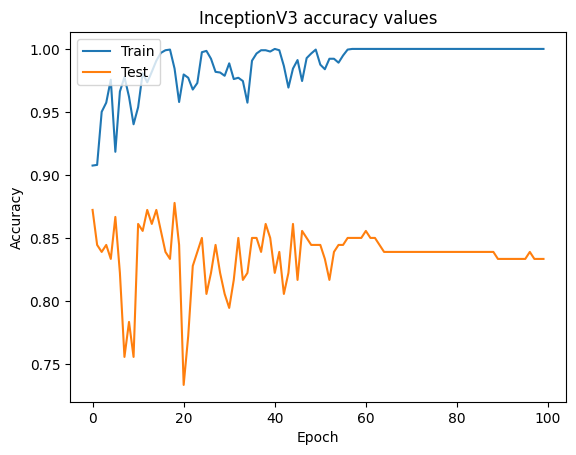

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('InceptionV3 accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

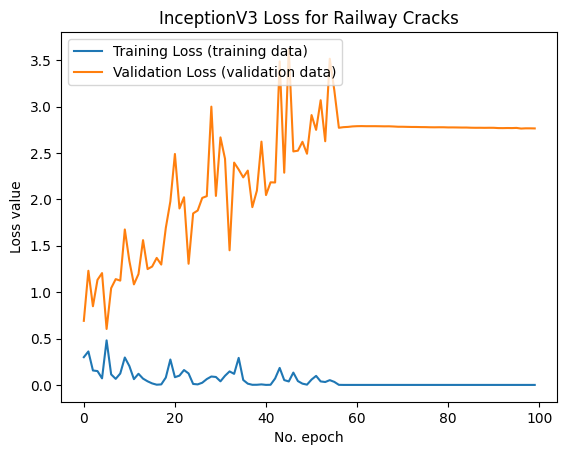

In [ ]:
plt.plot(model_history.history['loss'], label='Training Loss (training data)')
plt.plot(model_history.history['val_loss'], label='Validation Loss (validation data)')
plt.title('InceptionV3 Loss for Railway Cracks')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save('InceptionV3-cracks.keras')


## Testing

In [23]:
from keras.models import load_model
from google.colab.patches import cv2_imshow
trainedModel = load_model('/content/drive/MyDrive/ThesisData/Keras/KerasModels/inceptionv3-cracks.keras')

# Define class names
class_names = ['cracks', 'nocracks']
testCrack_path = '/content/drive/MyDrive/ThesisData/Keras/valid/crack'
testNoncrack_path = '/content/drive/MyDrive/ThesisData/Keras/valid/nocrack'


Single Image Prediction

In [ ]:
from google.colab.patches import cv2_imshow

img = cv2.imread("/content/drive/MyDrive/ThesisData/Keras/test/crack/Image-081_jpg.rf.396b72611e16c2b95ed58be25e1e4670.jpg")
image_resized= cv2.resize(img, (224,224))
cv2_imshow(img)
cv2.waitKey(0)
img=np.expand_dims(image_resized,axis=0)
print(img.shape)
class_names = ['cracks','nocracks']

pred=trainedModel.predict(img)
pr_cl=np.argmax(pred,axis=1)
output_class=class_names[np.argmax(pred)]

print("The predicted class is", output_class)



Multiple Image Prediction

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

# Initialize a dictionary to count the number of images per class
class_counts = {class_name: 0 for class_name in class_names}


# List all image files in the folder
image_files = [f for f in os.listdir(testCrack_path) if f.endswith(".jpg")]

for image_file in image_files:
    image_path = os.path.join(testCrack_path, image_file)
    img = cv2.imread(image_path)
    image_resized = cv2.resize(img, (150, 150))
    cv2_imshow(image_resized)
    cv2.waitKey(0)
    img = np.expand_dims(image_resized, axis=0)
    print("Image shape:", img.shape)

    # Make predictions
    pred = trainedModel.predict(img)
    predicted_class_index = np.argmax(pred)
    output_class = class_names[predicted_class_index]

    # Update the class count
    class_counts[output_class] += 1

    print("Predicted class:", output_class)
    print("Class probabilities:", pred)
    print("\n")

Count how many per class predictions

In [32]:
# Print the counts for each class
for class_name, count in class_counts.items():
    print(f"Count of {class_name}: {count}")

Count of cracks: 119
Count of nocracks: 24


# Model Resaving

In [ ]:
from keras.models import load_model
from google.colab.patches import cv2_imshow
trainedModel = load_model('/content/drive/MyDrive/ThesisData/Keras/KerasModels/resnet-50-cracks.keras')

trainedModel.save("resnet-50-cracks.h5") #
